# Lab 10: Pharmacogenomic Analysis - Drug Sensitivity in Breast Cancer

## Overview  
This analysis explores the inhibitory efficiency (IC50) of a drug in breast cancer using the **Genomics of Drug Sensitivity in Cancer (GDSC)** dataset. We compare various experiments by analyzing key biological and experimental features that influence drug response.

**Recall** that the IC50 represents the drug concentration needed to inhibit 50% of cell viability in cell line experiments.
<img src="dose-response-curve.png" alt="drawing" style="width:500px;"/>

## Topics Covered

### 1. Data Processing / Exploration
In this step, we will load the GDSC dataset and perform initial data processing and exploration. This includes:
- Loading the dataset and displaying summary statistics.
- Visualizing the distribution of key variables, such as the IC50 values, to understand the data better (cell lines, z_score, drug_name)

### 2. Framing the Question / Formatting the Data for ML
In this step, we will frame the machine learning question we want to answer. This includes:
- Defining the target variable (e.g., binary classification of drug sensitivity based on IC50 values) and the features (e.g., gene expression levels, mutation status).
- Splitting the data into training and testing sets to evaluate the performance of our models.

### 3. Implementing ML Models
In this step, we will implement and evaluate various machine learning models to predict drug sensitivity. This includes:
- Building a simple baseline model, such as logistic regression, to establish a performance benchmark.
- Implementing more advanced models, such as decision trees, random forests, or support vector machines, to improve prediction accuracy.
- Evaluating the performance of the models using appropriate metrics, such as or accuracy, F1-score, etc.
- Visualizing the results to interpret the model's performance and understand the key features influencing drug sensitivity.


## 1. Data Processing / Exploration

We will start by loading a semi-curated dataset, where the raw data is available from the Genomics of Drug Sensitivity in Cancer (GDSC) database (https://www.cancerrxgene.org/).

In [17]:
# Package imports - loading and plotting stuff
import pandas as pd, numpy as np, random
import matplotlib.pyplot as plt, seaborn as sns

# Load / quick formatting
raw_data = pd.read_csv("GDSC_DATASET.csv")  
raw_data.columns = [" ".join(x.split("\n")).lower() for x in raw_data.columns]
print(raw_data.columns)  # Check available column names

Index(['cosmic_id', 'cell_line_name', 'tcga_desc', 'drug_id', 'drug_name',
       'ln_ic50', 'auc', 'z_score', 'gdsc tissue descriptor 1',
       'gdsc tissue descriptor 2', 'cancer type (matching tcga label)',
       'microsatellite instability status (msi)', 'screen medium',
       'growth properties', 'cna', 'gene expression', 'methylation', 'target',
       'target_pathway'],
      dtype='object')


**Columns of GDSC dataset:**
1. **COSMIC_ID:** Unique identifier for the cell line from the COSMIC database.
2. **CELL_LINE_NAME:** Name of the cancer cell line used in the experiment.
3. **TCGA_DESC:** Description of the cancer type according to The Cancer Genome Atlas.
4. **DRUG_ID:** Unique identifier for the drug used in the experiment.
5. **DRUG_NAME:** Name of the drug used in the experiment.
6. **LN_IC50:** Natural log of the half-maximal inhibitory concentration (IC50).
7. **AUC:** Area Under the Curve, a measure of drug effectiveness.
9. **Z_SCORE:** Standardized score of the drug response, allowing comparison across different drugs and cell lines.
9. **GDSC Tissue descriptor 1:** Primary tissue type classification.
10. **GDSC Tissue descriptor 2:** Secondary tissue type classification.
11. **Cancer Type (matching TCGA label):** Cancer type according to TCGA classification.
12. **Microsatellite instability Status (MSI):** Indicates the cell line's MSI status.
13. **Screen Medium:** The growth medium used for culturing the cell line.
14. **Growth Properties:** Characteristics of how the cell line grows in culture.
15. **Copy Number Alterations (CNA):** Data on gene copy number changes in the cell line.
16. **Gene Expression:** Information on gene expression levels in the cell line.
17. **Methylation:** Data on DNA methylation patterns in the cell line.
18. **TARGET:** The molecular target(s) of the drug.
19. **TARGET_PATHWAY:** The biological pathway(s) targeted by the drug.

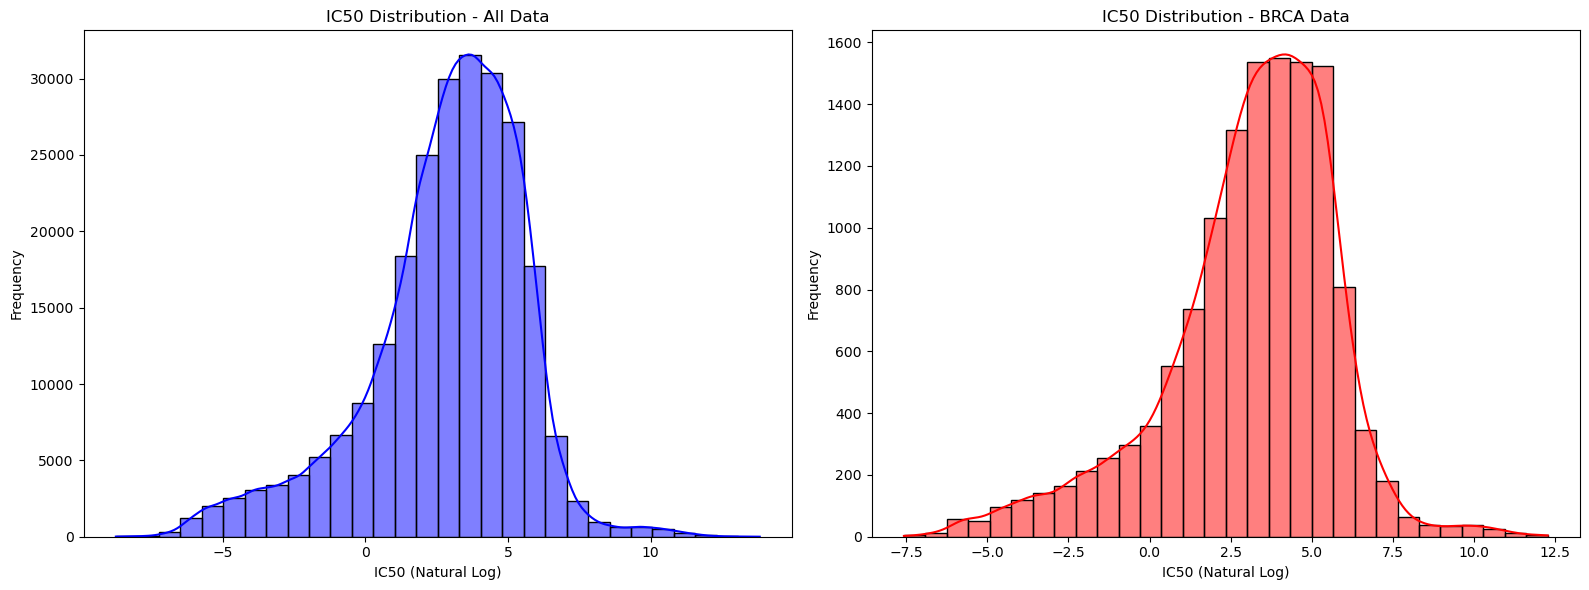

In [2]:
# Isolate the breast cancer data
brca_data = raw_data.copy()[raw_data["tcga_desc"] == "BRCA"]

# Visualize the IC50 Distribution for all data and our subset of interest
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(raw_data["ln_ic50"], bins=30, kde=True, color='blue', ax=axes[0])
axes[0].set_title('IC50 Distribution - All Data')
axes[0].set_xlabel("IC50 (Natural Log)")
axes[0].set_ylabel("Frequency")

sns.histplot(brca_data["ln_ic50"], bins=30, kde=True, color='red', ax=axes[1])
axes[1].set_title('IC50 Distribution - BRCA Data')
axes[1].set_xlabel("IC50 (Natural Log)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

33
tcga_desc
UNCLASSIFIED    45690
LUAD            15653
SCLC            13570
Name: count, dtype: int64
ln_ic50      1.000000
auc          0.762728
z_score      0.509209
drug_id      0.167820
cosmic_id   -0.009630
Name: ln_ic50, dtype: float64
Index(['cosmic_id', 'drug_id', 'ln_ic50', 'auc', 'z_score'], dtype='object')


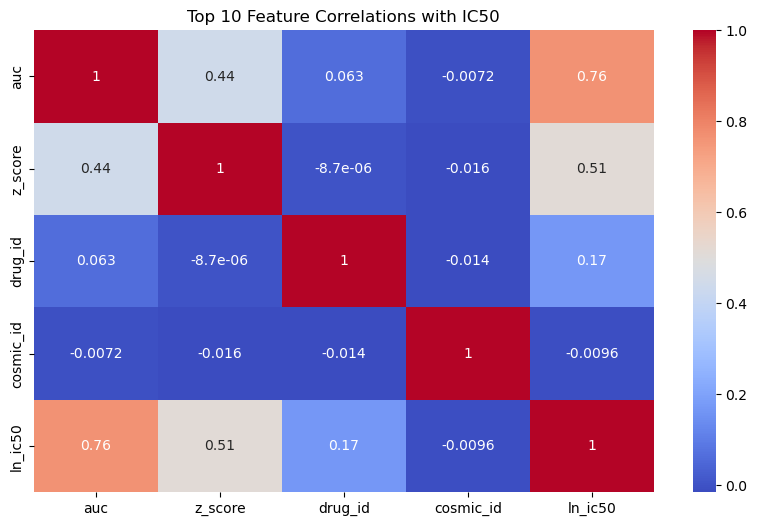


Mean ln_IC50 by microsatellite instability status (msi):
microsatellite instability status (msi)
MSI-H        2.554687
MSS/MSI-L    2.826101
Name: ln_ic50, dtype: float64

Mean ln_IC50 by screen medium:
screen medium
R        2.649653
D/F12    3.006025
Name: ln_ic50, dtype: float64


In [18]:
print(len(raw_data['tcga_desc'].unique()))
#How many different cancer types are represented? Which are the top 3 in terms of number of experiments available? 
print(raw_data['tcga_desc'].value_counts().head(3))

#. What are the correlations between numerical features and the target variable (IC50)? Is this expected?
numerical_features = raw_data.select_dtypes(include=[np.number])
correlations = numerical_features.corr()['ln_ic50'].sort_values(ascending=False)
print(correlations)

print(numerical_features.columns)

# Visualize the top 10 correlations with IC50
top_corr = correlations.drop(['ln_ic50']).abs().sort_values(ascending=False).head(10).index

plt.figure(figsize=(10, 6))
sns.heatmap(numerical_features[top_corr.tolist() + ['ln_ic50']].corr(), annot=True, cmap='coolwarm')
plt.title('Top 10 Feature Correlations with IC50')
plt.show()


# What is the distribution of IC50 values across different categories (e.g., MSI status, screen medium)?
#group by category and calculate mean IC50

categorical_cols = ['microsatellite instability status (msi)', 'screen medium'] 

for col in categorical_cols:
    if col in raw_data.columns:
        print(f"\nMean ln_IC50 by {col}:")
        print(raw_data.groupby(col)['ln_ic50'].mean().sort_values())

## Questions for Exploration

1. How many experiments are in this dataset (i.e., number of rows)?

        242,035

2. How many different cancer types are represented? Which are the top 3 in terms of number of experiments available? 

        33 cancer types (including unclassified), top3 : Unclassified, LUAD, SCLC

3. What are the correlations between numerical features and the target variable (IC50)? Is this expected? 
   
        Strong correlation. AUC (Area Under Curve) often measures drug sensitivity. It's expected to correlate with IC50 because both reflect drug response 
        A positive correlation with IC50 means higher z_score → higher IC50, i.e., less sensitivity.
        drug_id is likely a categorical or identifier column, so correlation here is not meaningful or expected.
        cosmic_id should not be expected to correlate with IC50.

4. What is the distribution of IC50 values across different categories (e.g., MSI status, screen medium)?
        MSI-H cells have a lower ln(IC50) → generally more sensitive to the drug.
        MSS/MSI-L cells show higher resistance.
        This is expected, as MSI-H tumors often have higher mutation loads and respond better to targeted or immunotherapies. 

        Cells grown in D/F12 medium tend to have higher IC50, indicating reduced sensitivity.
        This could be due to nutrient composition affecting drug uptake or metabolism.
        This is also expected, and highlights the importance of controlling for medium in experiments.



## 2. Framing the Question / Formatting the Data for ML
In this step, we will frame the machine learning question we want to answer. 

### Pairwise Comparison Approach  
- Each experiment is represented as a feature vector $X_a$ and $X_b$.  
- We compare the IC50 values ($y_a$, $y_b$) between two experiments to determine which experimental condition leads to higher or lower drug sensitivity.  
- This transforms the problem into a binary classification task, where the model predicts whether one condition results in an increase or decrease in IC50. 

### Features Considered  
- **Binary Features:**  
  - Microsatellite instability (MSI) status  
  - Screen medium  
  - Copy number alterations (CNA)  
  - Gene expression  
  - Methylation  

- **Ternary Feature:**  
  - Growth properties of cancer cells (adherent, semi-adherent, suspension)  

- **Drug Target Pathway:**  
  - Captures the molecular mechanism of action of the drug   

In [40]:
# Isolate the data of interest
cols_to_keep = ["microsatellite instability status (msi)", "screen medium", "cna", "gene expression", "methylation", "growth properties", "target_pathway"]              
y = brca_data.copy()["ln_ic50"]
X = brca_data.copy()[cols_to_keep] 

# Encode categorical features
X["microsatellite instability status (msi)"] = X["microsatellite instability status (msi)"].map({"MSS/MSI-L": 1, "MSI-H": 0})
X["growth properties"] = X["growth properties"].map({"Adherent": 0, "Semi-adherent": 1, "Suspension": 2})
X["screen medium"] = X["screen medium"].map({"D/F12": 0, "R": 1})
X["cna"] = X["cna"].map({"Y": 1, "N": 0})
X["gene expression"] = X["gene expression"].map({"Y": 1, "N": 0})
X["methylation"] = X["methylation"].map({"Y": 1, "N": 0})

# Encode drug target pathway
X = pd.get_dummies(X, columns=["target_pathway"]) 
# This will create binary columns for each target pathway because there are multiple categories . .map() only manually maps values to a few categories.
# X.head()
feature_names = X.columns

NOTE (ChatGPT, 2025 - ask for explanation)

`zip()` combines elements from multiple iterables (like lists or arrays) into pairs (or tuples)

`.to_numpy()` converts a Pandas DataFrame or Series into a NumPy array.
This is useful when:
You want to do fast numerical operations
You need to use functions (like machine learning models) that expect NumPy arrays

X.loc[idx[:, 0]] --> 

    X.loc[]: get all rows 

    X.loc[idx]: get all rows in idx 1D at index (a,b,c,d,e) 
    
    -> (feature1, feature2 at index a)// (feature1, feature2 at index b)....

    X.loc[ind[:,0]]: get all row in idx (a,b)-> first feature -> a


In [41]:
from sklearn.model_selection import train_test_split

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

# Generate pairwise indices for training and testing sets
def generate_pairwise_indices(X, y, n_pairs=80_000):
    idx = np.array([(a, b) for a, b in zip(random.choices(X.index, k=n_pairs), random.choices(X.index, k=n_pairs)) if a != b])
    X_diff = X.loc[idx[:, 0]].to_numpy() - X.loc[idx[:, 1]].to_numpy()
    y_diff = y.loc[idx[:, 0]].to_numpy() - y.loc[idx[:, 1]].to_numpy()
    y_diff = y_diff > 0
    return X_diff, y_diff # X: feature diff, y : ln_ic50 diff

# Generate pairwise training data
X_train_diff, y_train_diff = generate_pairwise_indices(X_train, y_train) #return X_diff, y_diff

# Generate pairwise testing data
X_test_diff, y_test_diff = generate_pairwise_indices(X_test, y_test, n_pairs=20_000)

# Display the shapes of the generated datasets
print("X_train_diff shape:", X_train_diff.shape)
print("y_train_diff shape:", y_train_diff.shape)
print("X_test_diff shape:", X_test_diff.shape)
print("y_test_diff shape:", y_test_diff.shape)




X_train_diff shape: (79996, 30)
y_train_diff shape: (79996,)
X_test_diff shape: (19993, 30)
y_test_diff shape: (19993,)


## 3. Implementing ML Models
In this step, we will implement and evaluate various machine learning models to predict drug sensitivity. 

Logistic Regression Test Accuracy: 0.6293
              precision    recall  f1-score   support

       False     0.6321    0.6178    0.6249      9993
        True     0.6265    0.6407    0.6335     10000

    accuracy                         0.6293     19993
   macro avg     0.6293    0.6293    0.6292     19993
weighted avg     0.6293    0.6293    0.6292     19993

Random Forest Test Accuracy: 0.6029
              precision    recall  f1-score   support

       False     0.6050    0.5921    0.5985      9993
        True     0.6009    0.6137    0.6072     10000

    accuracy                         0.6029     19993
   macro avg     0.6030    0.6029    0.6029     19993
weighted avg     0.6030    0.6029    0.6029     19993



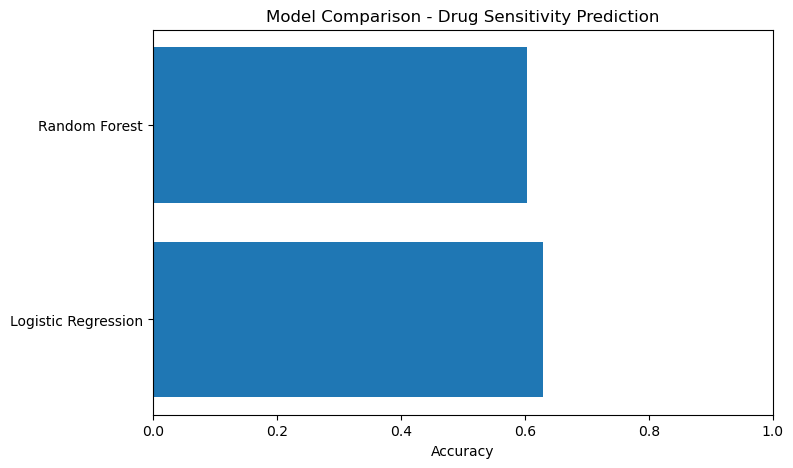

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Clean missing values 
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train_diff_clean = imputer.fit_transform(X_train_diff)
X_test_diff_clean = imputer.transform(X_test_diff)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
}
# Train and evaluate models
# for name, model in models.items():
#     model.fit(X_train_diff_clean, y_train_diff)
#     y_pred = model.predict(X_test_diff_clean)
#     acc = accuracy_score(y_test_diff, y_pred)
    
#     print(f"{name} Test Accuracy: {acc:.4f}")
#     print(classification_report(y_test_diff, y_pred, digits=4))

accuracies = {}
for name, model in models.items():
    model.fit(X_train_diff_clean, y_train_diff)
    y_pred = model.predict(X_test_diff_clean)
    acc = accuracy_score(y_test_diff, y_pred)
    accuracies[name] = acc
    
    print(f"{name} Test Accuracy: {acc:.4f}")
    print(classification_report(y_test_diff, y_pred, digits=4))
    
    

plt.figure(figsize=(8, 5))
plt.barh(list(accuracies.keys()), list(accuracies.values()))
plt.xlabel("Accuracy")
plt.title("Model Comparison - Drug Sensitivity Prediction")
plt.xlim(0, 1)
plt.show()



# Try something a little fancier (vroom vroom)
# INSERT CODE HERE



# Pretty plots and evaluation metrics!



## Questions for Exploration

1. How do the logistic regression and random forest models compare in terms of accuracy?
2. Which features are the most important in predicting drug sensitivity (IC50)?
3. Are there any features that consistently appear as important across different models? 
4. Are there any surprising or counterintuitive findings in the feature importances? (i.e., would this support or refute any related biological hypothesis?)
5. How robust are the models to changes in the training data? For example, how does the performance change if we use a different random seed for the train-test split?
6. How do the models perform on different subsets of the data (e.g., different cancer subtypes)?
7. What are the optimal hyperparameters for the logistic regression and random forest models?
8. How does the performance change with different hyperparameter settings?

Logistic Regression Test Accuracy: 0.6293
              precision    recall  f1-score   support

       False     0.6321    0.6178    0.6249      9993
        True     0.6265    0.6407    0.6335     10000

    accuracy                         0.6293     19993
   macro avg     0.6293    0.6293    0.6292     19993
weighted avg     0.6293    0.6293    0.6292     19993

Top 10 Logistic Regression Features:
target_pathway_JNK and p38 signaling            1.102658
target_pathway_Metabolism                       0.921512
target_pathway_p53 pathway                      0.872636
microsatellite instability status (msi)         0.490620
target_pathway_Hormone-related                  0.434235
target_pathway_Genome integrity                 0.407734
target_pathway_WNT signaling                    0.399785
target_pathway_Other                            0.396213
target_pathway_Chromatin other                  0.368316
target_pathway_Chromatin histone methylation    0.342940
dtype: float64


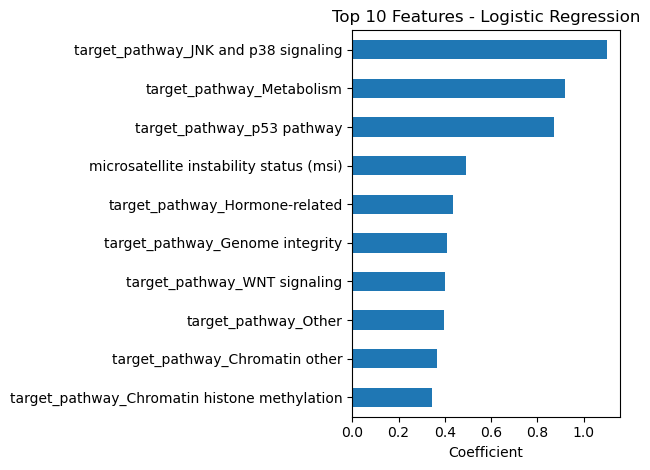

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt

# Fit logistic regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_diff_clean, y_train_diff)

# Predict
y_pred_log = log_reg.predict(X_test_diff_clean)

# Evaluate
acc_log = accuracy_score(y_test_diff, y_pred_log)
print(f"Logistic Regression Test Accuracy: {acc_log:.4f}")
print(classification_report(y_test_diff, y_pred_log, digits=4))

# Feature importance
importance_log = pd.Series(log_reg.coef_[0], index=feature_names)
top_10_log = importance_log.sort_values(ascending=False).head(10)
print("Top 10 Logistic Regression Features:")
print(importance_log.sort_values(ascending=False).head(10))


# Plot
top_10_log.plot(kind='barh')
plt.title("Top 10 Features - Logistic Regression")
plt.xlabel("Coefficient")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Random Forest Test Accuracy: 0.6029
              precision    recall  f1-score   support

       False     0.6050    0.5921    0.5985      9993
        True     0.6009    0.6137    0.6072     10000

    accuracy                         0.6029     19993
   macro avg     0.6030    0.6029    0.6029     19993
weighted avg     0.6030    0.6029    0.6029     19993

Top 10 Random Forest Features:
screen medium                                       0.112959
target_pathway_Mitosis                              0.075365
microsatellite instability status (msi)             0.072551
growth properties                                   0.062822
target_pathway_PI3K/MTOR signaling                  0.044941
methylation                                         0.042899
target_pathway_Apoptosis regulation                 0.036918
target_pathway_Cell cycle                           0.034410
target_pathway_Protein stability and degradation    0.033467
target_pathway_Other                                0.033

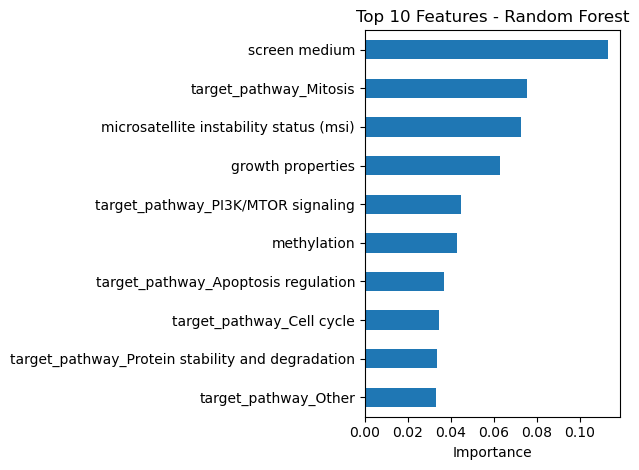

In [47]:
from sklearn.ensemble import RandomForestClassifier

# Fit random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_diff_clean, y_train_diff)

# Predict
y_pred_rf = rf_model.predict(X_test_diff_clean)

# Evaluate
acc_rf = accuracy_score(y_test_diff, y_pred_rf)
print(f"Random Forest Test Accuracy: {acc_rf:.4f}")
print(classification_report(y_test_diff, y_pred_rf, digits=4))

# For random forest
importance_rf = pd.Series(rf_model.feature_importances_, index=feature_names)
top_10_rf = importance_rf.sort_values(ascending=False).head(10)
print("Top 10 Random Forest Features:")
print(importance_rf.sort_values(ascending=False).head(10))

# Plot
top_10_rf.plot(kind='barh')
plt.title("Top 10 Features - Random Forest")
plt.xlabel("Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
